<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment2/blob/main/partA/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
import torch
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [ ]:
wandb.login(key='72a114321dd97dbf11db7b15eb05b2660c2faa94')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
!cp -a '/content/drive/MyDrive/inaturalist_12K/' '/content/inaturalist/'

In [ ]:
def prepare_dataset(batch_size, data_aug):
    # Define the dataset directory
    train_dir = '/content/inaturalist/train'
    test_dir = '/content/inaturalist/val'

    if data_aug :
        transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else :
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    validation_ratio = 0.2
    class_labels = [label for _, label in train_dataset]

    class_id = defaultdict(list)
    for idx, label in enumerate(class_labels):
        class_id[label].append(idx)

    train_indices = []
    val_indices = []

    for y, ids in class_id.items():
        num_samples = len(ids)
        val_samples = int(validation_ratio * num_samples)
        np.random.shuffle(ids)  # Shuffle indices for random selection
        train_indices.extend(ids[val_samples:])
        val_indices.extend(ids[:val_samples])

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [ ]:
class SpeciesCNN(nn.Module):
    def __init__(self, num_classes, num_filters=32, filter_size=[3, 3, 3, 3, 3], dense_neurons=512, activation = 'ReLU', batch_norm = False, dropout_val = 0.0, filter_org = 'double'):
        super(SpeciesCNN, self).__init__()
        act_func = nn.ReLU()
        match activation :
            case 'ReLU':
                act_func = nn.ReLU
            case 'GELU':
                act_func = nn.GELU
            case 'SiLU':
                act_func = nn.SiLU
            case 'Mish':
                act_func = nn.Mish
            case 'LeakyReLU':
                act_func = nn.LeakyReLU
            case 'Sigmoid':
                act_func = nn.Sigmoid

        match filter_org :
            case 'same':
                filters = [num_filters] * 5
            case 'double':
                filters = [num_filters * (2 ** i) for i in range(5)]
            case 'half':
                filters = [num_filters // (2 ** i) for i in range(5)]



        # Convolutional block 1
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=filters[0], kernel_size=filter_size[0], padding=1)
        self.act_1 = act_func()
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        if batch_norm :
            self.batch_1 = nn.BatchNorm2d(filters[0])

        # Convolutional block 2
        self.conv_2 = nn.Conv2d(in_channels=filters[0], out_channels=filters[1], kernel_size=filter_size[1], padding=1)
        self.act_2 = act_func()
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        if batch_norm :
            self.batch_2 = nn.BatchNorm2d(filters[1])

        # Convolutional block 3
        self.conv_3 = nn.Conv2d(in_channels=filters[1], out_channels=filters[2], kernel_size=filter_size[2], padding=1)
        self.act_3 = act_func()
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        if batch_norm :
            self.batch_3 = nn.BatchNorm2d(filters[2])

        # Convolutional block 4
        self.conv_4 = nn.Conv2d(in_channels=filters[2], out_channels=filters[3], kernel_size=filter_size[3], padding=1)
        self.act_4 = act_func()
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
        if batch_norm :
            self.batch_4 = nn.BatchNorm2d(filters[3])

        # Convolutional block 5
        self.conv_5 = nn.Conv2d(in_channels=filters[3], out_channels=filters[4], kernel_size=filter_size[4], padding=1)
        self.act_5 = act_func()
        self.pool_5 = nn.MaxPool2d(kernel_size=2, stride=2)
        if batch_norm :
            self.batch_5 = nn.BatchNorm2d(filters[4])


        self.flatten = nn.Flatten()

        # Dense layers
        self.fc1 = nn.LazyLinear(out_features=dense_neurons, bias=True, device=None, dtype=None)
        self.fc1_activation = act_func()
        if dropout_val > 0.0 :
            self.dropout1 = nn.Dropout(dropout_val)
        self.fc2 = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        x = self.pool_1(self.act_1(self.conv_1((x))))
        if hasattr(self, 'batch_1'):
            x = self.batch_1(x)

        x = self.pool_2(self.act_2(self.conv_2((x))))
        if hasattr(self, 'batch_2'):
            x = self.batch_2(x)

        x = self.pool_3(self.act_3(self.conv_3((x))))
        if hasattr(self, 'batch_3'):
            x = self.batch_3(x)

        x = self.pool_4(self.act_4(self.conv_4((x))))
        if hasattr(self, 'batch_4'):
            x = self.batch_4(x)

        x = self.pool_5(self.act_5(self.conv_5((x))))
        if hasattr(self, 'batch_5'):
            x = self.batch_5(x)

        x = self.flatten(x)
        x = self.fc1_activation(self.fc1(x))
        if hasattr(self, 'dropout1'):
            x = self.dropout1(x)
        x = F.softmax(self.fc2(x), dim=1)

        return x

# Define the model
model = SpeciesCNN(num_classes=10)

# Print the model architecture
print(model)


SpeciesCNN(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act_3): ReLU()
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act_5): ReLU()
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LazyLinear(in_

In [ ]:
def train_per_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train(True)  # Set the model to training mode

    train_loss = 0.0
    correct_ans = 0
    num_samples = 0

    for data in tqdm(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        z, predicted = torch.max(outputs, 1)
        correct_ans += (predicted == labels).sum().item()
        num_samples += labels.size(0)


    epoch_loss = train_loss / num_samples
    epoch_accuracy = correct_ans / num_samples

    return epoch_loss, epoch_accuracy

In [ ]:
def val_per_epoch(model, val_loader, loss_func, optimizer, epoch):
    model.eval()

    correct_ans = 0
    num_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            z, predicted = torch.max(outputs, 1)
            correct_ans += (predicted == labels).sum().item()
            num_samples += labels.size(0)

    epoch_val_loss = val_loss / num_samples
    epoch_val_accuracy = correct_ans / num_samples

    return epoch_val_loss, epoch_val_accuracy


In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        train_loss, train_acc = train_per_epoch(model, train_loader, loss_func, optimizer, epoch)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
        val_loss, val_acc = val_per_epoch(model, val_loader, loss_func, optimizer, epoch)
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        #wandb.log({'train_loss': train_loss, 'train_accuracy': train_acc, 'val_loss' : val_loss, 'val_accuracy' : val_acc, 'epochs' : epoch + 1})

    return model

In [ ]:
sweep_config = {
    'method' : 'random',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5]
        },
        'num_filters' : {
            'values' : [32, 64]
        },
        'filter_size' : {
            'values' : [[3, 3, 3, 3, 3], [2, 2, 2, 2, 2]]
        },
        'dropout': {
            'values' : [0.2, 0.3, 0.4, 0.5]
        },
        'batch_size' : {
            'values' : [32, 64]
        },
        'data_aug' :  {
            'values' : [True, False]
        },
        'batch_norm' : {
            'values' : [True, False]
        },
        'learning_rate' : {
            'values' : [1e-3, 5e-3, 1e-4]
        },
        'activation' : {
            'values' : ['Mish', 'GELU', 'ReLU', 'SiLU']
        },
        'filter_org' : {
            'values' : ['same', 'double']
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_2', entity = "cs23m009")

Create sweep with ID: c94t05e9
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_2/sweeps/c94t05e9


In [ ]:
# Function to train the model
def test_model(model, test_loader, loss_func, optimizer):
    model.eval()

    correct_ans = 0
    num_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            z, predicted = torch.max(outputs, 1)
            correct_ans += (predicted == labels).sum().item()
            num_samples += labels.size(0)

    test_loss = val_loss / num_samples
    test_acc = correct_ans / num_samples
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

In [ ]:
def main():
    with wandb.init() as run:
        run_name = 'a_{}_bs_{}_lr_{}_e_{}_d_{}_aug_{}_bn_{}_fs_{}_fo_{}'.format(wandb.config.activation, wandb.config.batch_size, wandb.config.learning_rate, wandb.config.epochs, wandb.config.dropout, wandb.config.data_aug, wandb.config.batch_norm, wandb.config.filter_size, wandb.config.filter_org)
        wandb.run.name = run_name

        #Prepare Data
        train_loader, val_loader, test_loader = prepare_dataset(wandb.config['batch_size'], wandb.config['data_aug'])
        # Define the model
        model = SpeciesCNN(num_classes=10, num_filters = wandb.config['num_filters'], filter_size = wandb.config['filter_size'], activation = wandb.config['activation'], batch_norm = wandb.config['batch_norm'], dropout_val=wandb.config['dropout'], filter_org = wandb.config['filter_org'])
        model.to(device)
        # Define loss function and optimizer
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=wandb.config['learning_rate'])
        model = train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs=wandb.config['epochs'])


wandb.agent(sweep_id, function = main, count = 3)
wandb.finish()

wandb: Agent Starting Run: wefy405d with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_aug: False
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_org: double
wandb: 	filter_size: [2, 2, 2, 2, 2]
wandb: 	learning_rate: 0.005
wandb: 	num_filters: 32
wandb: Currently logged in as: cs23m009. Use `wandb login --relogin` to force relogin


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/5, Loss: 2.2970, Accuracy: 0.1211


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5, Val Loss: 2.2636, Val Accuracy: 0.1675


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/5, Loss: 2.2719, Accuracy: 0.1596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5, Val Loss: 2.2647, Val Accuracy: 0.1790


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/5, Loss: 2.2550, Accuracy: 0.1857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5, Val Loss: 2.2355, Val Accuracy: 0.2160


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/5, Loss: 2.2536, Accuracy: 0.1858


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5, Val Loss: 2.3113, Val Accuracy: 0.1345


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/5, Loss: 2.3435, Accuracy: 0.1135


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5, Val Loss: 2.3617, Val Accuracy: 0.0995


epochs,▁▃▅▆█
train_accuracy,▂▅██▁
train_loss,▄▂▁▁█
val_accuracy,▅▆█▃▁
val_loss,▃▃▁▅█
epochs,5
train_accuracy,0.11351
train_loss,2.34351
val_accuracy,0.0995
val_loss,2.36165


wandb: Agent Starting Run: x7pufgxy with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_aug: False
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	filter_org: double
wandb: 	filter_size: [2, 2, 2, 2, 2]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 64


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/5, Loss: 2.2199, Accuracy: 0.2315


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5, Val Loss: 2.1946, Val Accuracy: 0.2645


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/5, Loss: 2.1987, Accuracy: 0.2571


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5, Val Loss: 2.1990, Val Accuracy: 0.2575


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/5, Loss: 2.1727, Accuracy: 0.2843


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5, Val Loss: 2.1692, Val Accuracy: 0.2880


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/5, Loss: 2.1656, Accuracy: 0.2897


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5, Val Loss: 2.1842, Val Accuracy: 0.2735


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/5, Loss: 2.1416, Accuracy: 0.3164


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5, Val Loss: 2.1625, Val Accuracy: 0.2935


epochs,▁▃▅▆█
train_accuracy,▁▃▅▆█
train_loss,█▆▄▃▁
val_accuracy,▂▁▇▄█
val_loss,▇█▂▅▁
epochs,5
train_accuracy,0.31643
train_loss,2.14163
val_accuracy,0.2935
val_loss,2.16251


wandb: Agent Starting Run: froxwrao with config:
wandb: 	activation: GELU
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_aug: False
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	filter_org: same
wandb: 	filter_size: [2, 2, 2, 2, 2]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 64


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/5, Loss: 2.2599, Accuracy: 0.1952


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/5, Val Loss: 2.2665, Val Accuracy: 0.1930


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/5, Loss: 2.2611, Accuracy: 0.1984


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/5, Val Loss: 2.2492, Val Accuracy: 0.2110


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/5, Loss: 2.2453, Accuracy: 0.2148


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/5, Val Loss: 2.3052, Val Accuracy: 0.1545


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/5, Loss: 2.2647, Accuracy: 0.1957


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/5, Val Loss: 2.2604, Val Accuracy: 0.2000


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/5, Loss: 2.2479, Accuracy: 0.2119


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/5, Val Loss: 2.2653, Val Accuracy: 0.1960


epochs,▁▃▅▆█
train_accuracy,▁▂█▁▇
train_loss,▆▇▁█▂
val_accuracy,▆█▁▇▆
val_loss,▃▁█▂▃
epochs,5
train_accuracy,0.21191
train_loss,2.24786
val_accuracy,0.196
val_loss,2.26533


In [ ]:
train_loader, val_loader, test_loader = prepare_dataset(32, False)

In [ ]:
model = SpeciesCNN(num_classes=10, num_filters = 32, filter_size = [2, 2, 2, 2, 2], activation = 'ReLU', batch_norm = True, dropout_val=0.2, filter_org = 'same')
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, train_loader, val_loader, loss_func, optimizer, 5)
test_model(model, test_loader,loss_func, optimizer)

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/5, Loss: 2.2098, Accuracy: 0.2440


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/5, Val Loss: 2.1585, Val Accuracy: 0.3025


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/5, Loss: 2.1363, Accuracy: 0.3272


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/5, Val Loss: 2.1318, Val Accuracy: 0.3225


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/5, Loss: 2.1013, Accuracy: 0.3661


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/5, Val Loss: 2.1155, Val Accuracy: 0.3385


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/5, Loss: 2.0758, Accuracy: 0.3930


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/5, Val Loss: 2.0972, Val Accuracy: 0.3720


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/5, Loss: 2.0465, Accuracy: 0.4293


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/5, Val Loss: 2.0973, Val Accuracy: 0.3630


  0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 2.0964, Test Accuracy: 0.3625


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


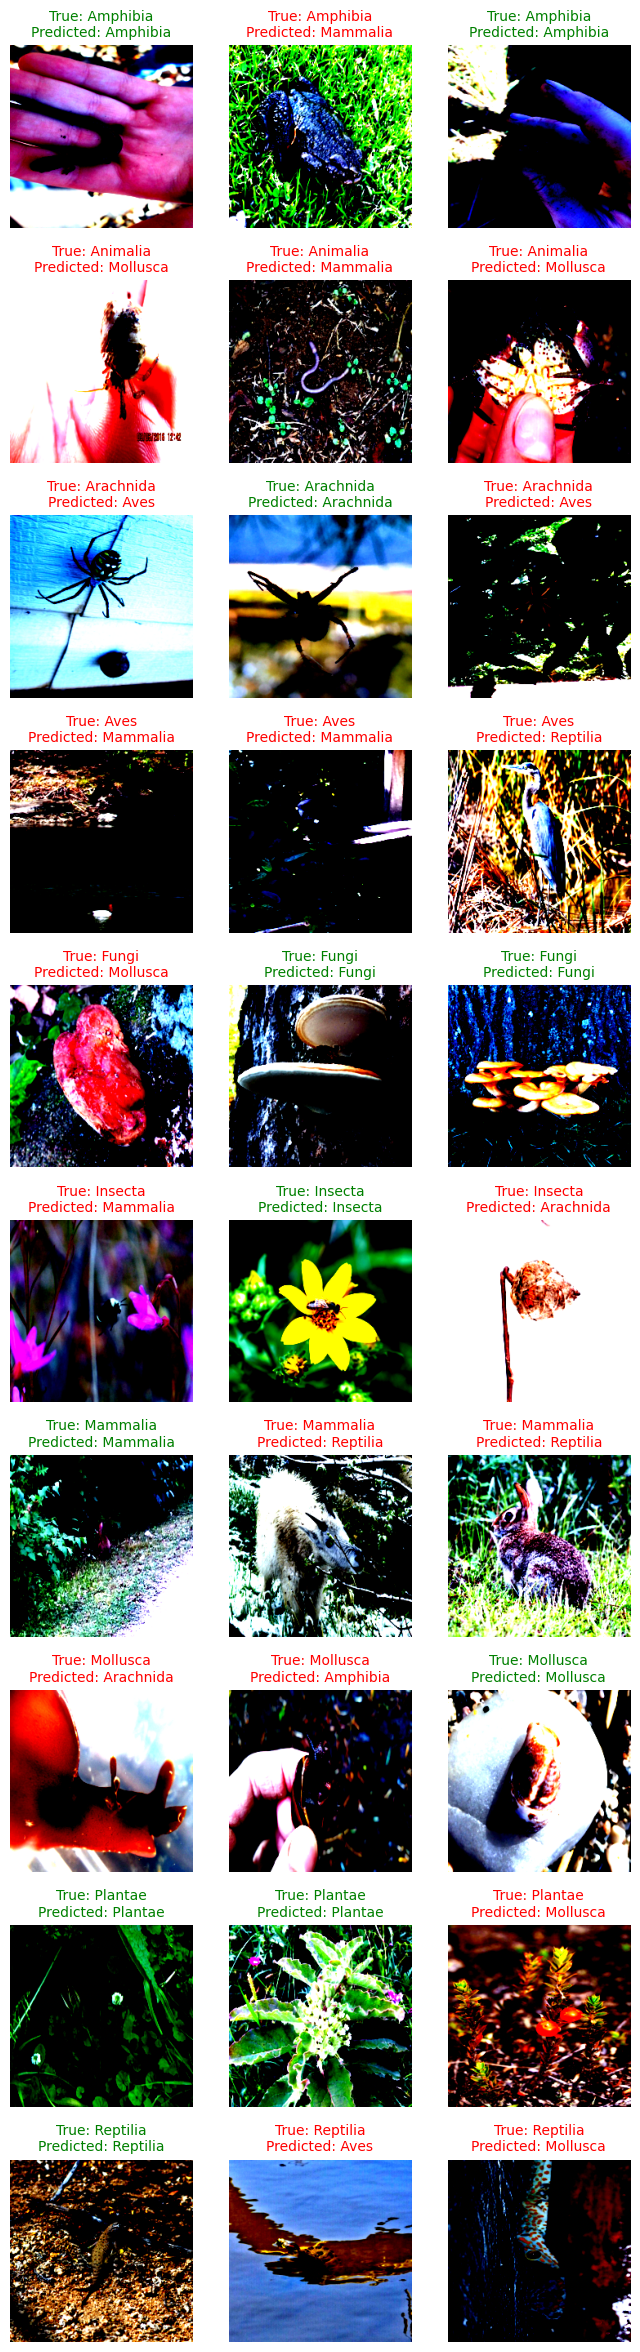

In [ ]:
def get_class(idx):
    return test_loader.dataset.classes[idx]


def plot_test_data():
    wandb.init(project='DL_Assignment_2', entity = "cs23m009")
    model.eval()
    model.to('cpu')

    fig, axes = plt.subplots(10, 3, figsize=(8, 30))

    axes = axes.flatten()

    # Iterate over each class
    for index in range(10):
        class_indices = [i for i, y in enumerate(test_loader.dataset.targets) if y == index]
        sample_idx = np.random.choice(class_indices, size=3, replace=False)

        for i, idx in enumerate(sample_idx):
            img, true_label = test_loader.dataset[idx]

            with torch.no_grad():

                output = model(img.unsqueeze(0))
                _, pred_val = torch.max(output, 1)

            # Convert the image to numpy array and transpose
            img = img.numpy().transpose((1, 2, 0))
            img = np.clip(img, 0, 1)  # Clip image values between 0 and 1

            # Plot the image with true and predicted labels
            axes[index * 3 + i].imshow(img)

            axes[index * 3 + i].axis('off')
            axes[index * 3 + i].set_title(f'True: {get_class(true_label)}\nPredicted: {get_class(pred_val.item())}',fontsize=10, color='green' if true_label == pred_val else 'red')

    image = wandb.Image(plt)
    wandb.log({"Q4] Sample Predictions": image})
    wandb.finish()
    plt.show()

plot_test_data()
